In [1]:
script = False
cluster = False

import numpy as np
import math
import pandas as pd
from memory_profiler import memory_usage
import time
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
plt.style.use('dark_background')
import random
from scipy.stats import skewnorm
import copy

if(script): 
    from tqdm import tqdm
else:
    from tqdm.notebook import tqdm

from astropy.io import fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy.visualization import make_lupton_rgb

import lenstronomy.Util.param_util as param
import lenstronomy.Util.util as util
import lenstronomy.Plots.plot_util as plot_util
from lenstronomy.SimulationAPI.sim_api import SimAPI
from lenstronomy.LensModel.lens_model import LensModel
from lenstronomy.LensModel.lens_model_extensions import LensModelExtensions
from lenstronomy.LensModel.Solver.lens_equation_solver import LensEquationSolver

import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [2]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)

In [3]:
DES_camera = {'read_noise': 7.,  # std of noise generated by read-out (in units of electrons)
               'pixel_scale': 0.2637,  # scale (in arcseconds) of pixels
               'ccd_gain': 4.#6.  # electrons/ADU (analog-to-digital unit). A gain of 8 means that the camera digitizes the CCD signal so that each ADU corresponds to 8 photoelectrons.
              }

DES_g_band_obs = {'exposure_time': 90.,  # exposure time per image (in seconds)
                   'sky_brightness': 35.01,  # sky brightness (in magnitude per square arcseconds)
                   'magnitude_zero_point': 30,  # magnitude in which 1 count per second per arcsecond square is registered (in ADU's)
                   'num_exposures': 10.,  # number of exposures that are combined
                   'seeing': 1.12,  # full width at half maximum of the PSF (if not specific psf_model is specified)
                   'psf_type': 'GAUSSIAN',  # string, type of PSF ('GAUSSIAN' and 'PIXEL' supported)
                   'kernel_point_source': None  # 2d numpy array, model of PSF centered with odd number of pixels per axis (optional when psf_type='PIXEL' is chosen)
                  }

DES_r_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 34.7,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 10.,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

DES_i_band_obs = {'exposure_time': 90.,  
                   'sky_brightness': 35.1,  
                   'magnitude_zero_point': 30,  
                   'num_exposures': 10.,  
                   'seeing': 1.12,  
                   'psf_type': 'GAUSSIAN', 
                  }

numpix = 45 # 45

kwargs_g_band = util.merge_dicts(DES_camera, DES_g_band_obs)
kwargs_r_band = util.merge_dicts(DES_camera, DES_r_band_obs)
kwargs_i_band = util.merge_dicts(DES_camera, DES_i_band_obs)

kwargs_numerics = {'point_source_supersampling_factor': 10}

cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Ob0=0.)

In [4]:
def simulation(redshifts, lens, kwargs_bands):
   
    kwargs_model_physical = {'lens_model_list': ['SIE'], 'lens_redshift_list': [redshifts['lens']],  
        'lens_light_model_list': ['SERSIC_ELLIPSE'], 'source_light_model_list': ['SERSIC_ELLIPSE'],  
         'source_redshift_list': [redshifts['source1']], 'cosmo': cosmo, 'z_source': redshifts['source1']} 
                          
    kwargs_g_band, kwargs_r_band, kwargs_i_band = kwargs_bands[0], kwargs_bands[1], kwargs_bands[2]
    
    sim_g = SimAPI(numpix=numpix, kwargs_single_band=kwargs_g_band, kwargs_model=kwargs_model_physical)
    sim_r = SimAPI(numpix=numpix, kwargs_single_band=kwargs_r_band, kwargs_model=kwargs_model_physical)
    sim_i = SimAPI(numpix=numpix, kwargs_single_band=kwargs_i_band, kwargs_model=kwargs_model_physical)
    
    #lens mass model
    kwargs_mass = [{'sigma_v': lens['sigma'], 'center_x': 0, 'center_y': 0, 'e1': lens['e1'], 'e2': lens['e2']}]
    kwargs_lens = sim_g.physical2lensing_conversion(kwargs_mass=kwargs_mass)
        
    return(kwargs_lens[0]['theta_E'])


In [5]:
def simulations_from_data(lenses, complete_data, num):
    num_sim = 0
    thetaE_list = []
    zlens_list = np.linspace(0.1, 1.4, num)

    lens_model_list = ['SIE']
    kwargs_bands = [kwargs_g_band, kwargs_r_band, kwargs_i_band]
    
    with tqdm(total=num) as pbar:
        while (num_sim < num):
            z_lens = zlens_list[num_sim] 
            z_source1 = 1.5 
            
            redshifts = {'lens': z_lens, 'source1': z_source1}
            e1, e2 = 0, 0 
            lens = {'sigma': 350, 'e1': e1, 'e2': e2} #single: 300-650
            theta_e = simulation(redshifts, lens, kwargs_bands)
            
            if(not math.isnan(theta_e)):
                thetaE_list.append(theta_e)
                num_sim += 1
                pbar.update(1)
                
    return(zlens_list, thetaE_list)


In [6]:
def run_everything(seed, num_sim, name_file):
    seed_everything(seed)

    hdu_list = fits.open(lenses_path)
    lenses = hdu_list[1].data 
    complete_data = hdu_list[2].data[:]
    complete_data = Table(complete_data)
    complete_data = complete_data.to_pandas()
    complete_data = complete_data.rename({'ZSPEC': 'Z_LENS'}, axis=1)
    print(len(complete_data))
    hdu_list.close()
    
    zlens_list, thetaE_list = simulations_from_data(lenses, complete_data, num_sim)
    
    return(zlens_list, thetaE_list)

In [7]:
inipath = '/Users/jimenagonzalez/research/DSPL/Simulations-Double-Source-Gravitational-Lensing/'
lenses_path = inipath + 'Data/Sim_complete/new_all_redmagic/' + 'all_redmagic_final.fits'

In [8]:
seed, num_sim, filename = 6, 100, 'SIE' # 4 2 False other

zlens_list, thetaE_list = run_everything(int(seed), int(num_sim), filename)

50380


  0%|          | 0/100 [00:00<?, ?it/s]

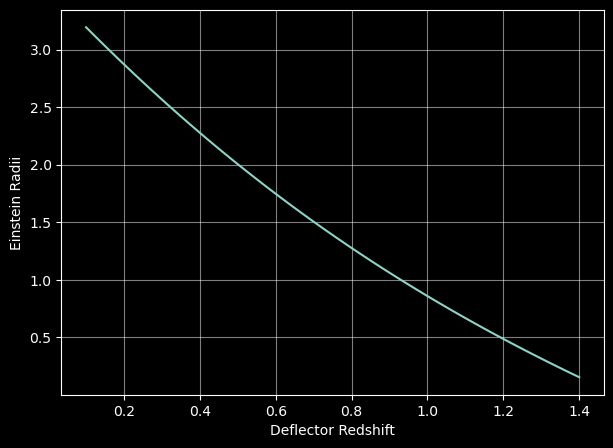

In [11]:
plt.figure(figsize=(7,5))
plt.plot(zlens_list, thetaE_list)
plt.xlabel('Deflector Redshift')
plt.ylabel('Einstein Radii')
plt.grid('both', alpha=0.5)
plt.show()